# Training a CNN + FNO on the Shallow Water equations on 2D plane


### Load packages

In [598]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

from utils import *

### Functions

In [599]:
# Load and execute the notebook
with open('CNN-linear-SWE-sphere-1D.ipynb', 'r') as f:
    nb_content = f.read()
exec(nb_content)

# Use functions defined in the other notebook
#result = some_function(args)


### Load data from h5 file

In [600]:
Nx = 50
tend = 5

# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')




Q_all
t_all
x
y
Loaded Q_all with shape (63, 3, 50, 50)
Loaded t_all with shape (63,)
Loaded x with shape (50,)
Loaded y with shape (50,)


In [601]:
h_all = Q_all[:, 0, :, :]


In [602]:
def prepare_data_2D(h_all, p_train, p_val):
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]

    # Target u (one time step after a)
    u = h_all[1:]
    n = len(h_all)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


In [603]:
## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

n_train = 37, n_val = 12, n_test = 14
torch.Size([37, 50, 50]) torch.Size([37, 50, 50]) torch.Size([12, 50, 50]) torch.Size([12, 50, 50]) torch.Size([13, 50, 50]) torch.Size([13, 50, 50])


## CNN

In [604]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, spatial_steps, output_size, num_filters=64, kernel_size=3, num_layers=4):
        super(CNNFlowmap, self).__init__()
        self.conv = nn.Conv2d(input_channels, num_filters, kernel_size, padding=1)
        #self.conv2 = nn.Conv2d(batch_size, batch_size, kernel_size = 1)
        self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=1)  # kernel_size=1 preserves spatial size

    def forward(self, x):
        # Input shape: [batch_size, seq_length, spatial_steps]
        x = x
        x = self.conv(x)       # Apply convolutional layers
        x = F.relu(x)          # Apply ReLU activation
        x = self.final_conv(x)
        x = x.squeeze(1)       # Remove channel dimension
        #x = self.conv2(x)
        #x = self.fc(x)         # Apply fully connected layers
        return x
    
input_channels = 10 # seq_length
output_channels = 1
spatial_steps = Nx
output_size = 50
batch_size = 16

# Instantiate the CNN model
model = CNNFlowmap(input_channels, spatial_steps, output_size)
print(model)

# Example forward pass
batch_x = torch.randn(n_train-10, input_channels, spatial_steps, spatial_steps)
print("Input shape:", batch_x.shape)
output = model(batch_x)
print("Output shape:", output.shape)

CNNFlowmap(
  (conv): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)
Input shape: torch.Size([27, 10, 50, 50])
Output shape: torch.Size([27, 50, 50])


In [605]:
# Prepare data in sequences
def prepare_data_sequences_2D(train_x, train_y, seq_length):
    # Fetch the dimensions of the input data
    timesteps, spatial_steps_x, spatial_steps_y = train_x.shape[0], train_x.shape[1], train_x.shape[2]

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, spatial_steps_x, spatial_steps_y))
    y_seq = torch.zeros((n_sequences, spatial_steps_x, spatial_steps_y))

    for i in range(n_sequences):
        x_seq[i] = train_x[i:i + seq_length]
        y_seq[i] = train_y[i + seq_length]
    return x_seq, y_seq

In [606]:
# Prepare data in sequences
seq_length = 10

X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

X_input_val, X_output_val = prepare_data_sequences_2D(val_x, val_y, seq_length)
X_input_test, X_output_test = prepare_data_sequences_2D(test_x, test_y, seq_length)



torch.Size([27, 10, 50, 50]) torch.Size([27, 50, 50])


In [607]:
batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

# Loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_train = []
loss_val = []

# Time training
start = time.time()

# Training loop
n_epochs = 500
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = loss_fn(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)
    
    # Average loss
    epoch_train_loss /= len(train_loader.dataset)
    epoch_val_loss /= len(val_loader.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}, Val loss = {epoch_val_loss:.6f}")

# Time training
end = time.time()
print(f"Training time: {end - start:.2f}s")
    


Epoch 0/500: Train loss = 1.837474, Val loss = 1.298036
Epoch 10/500: Train loss = 0.141886, Val loss = 0.164733
Epoch 20/500: Train loss = 0.017952, Val loss = 0.012240
Epoch 30/500: Train loss = 0.014229, Val loss = 0.013367
Epoch 40/500: Train loss = 0.014923, Val loss = 0.013064
Epoch 50/500: Train loss = 0.013093, Val loss = 0.011002
Epoch 60/500: Train loss = 0.011633, Val loss = 0.009853
Epoch 70/500: Train loss = 0.010189, Val loss = 0.008470
Epoch 80/500: Train loss = 0.008843, Val loss = 0.007213
Epoch 90/500: Train loss = 0.007796, Val loss = 0.006242
Epoch 100/500: Train loss = 0.006832, Val loss = 0.005369
Epoch 110/500: Train loss = 0.005911, Val loss = 0.004547
Epoch 120/500: Train loss = 0.005058, Val loss = 0.003809
Epoch 130/500: Train loss = 0.004292, Val loss = 0.003159
Epoch 140/500: Train loss = 0.003632, Val loss = 0.002622
Epoch 150/500: Train loss = 0.003077, Val loss = 0.002182
Epoch 160/500: Train loss = 0.002617, Val loss = 0.001833
Epoch 170/500: Train loss

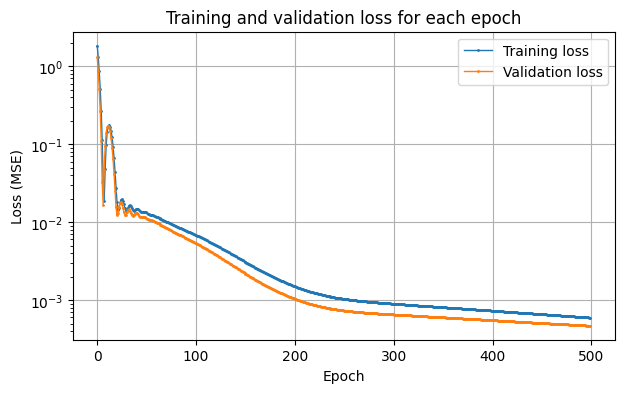

In [608]:
plt.figure(figsize=(7, 4))
plt.plot(loss_train, '.-', label='Training loss', linewidth=1, markersize=2)
plt.plot(loss_val, '.-', label='Validation loss', linewidth=1, markersize=2)
plt.yscale('log')
plt.legend()
plt.grid()
plt.title('Training and validation loss for each epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')

plt.show()

### Make predictions

In [609]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(X_input_train).cpu().detach().numpy()
    pred_val = model(X_input_val).cpu().detach().numpy()
    pred_test = model(X_input_test).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), X_output_train).item()
val_loss = loss_fn(torch.tensor(pred_val), X_output_val).item()
test_loss = loss_fn(torch.tensor(pred_test), X_output_test).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

X_all, Y_all = prepare_data_sequences_2D(torch.tensor(a, dtype=torch.float32), torch.tensor(u, dtype=torch.float32), seq_length)

# Make predictions
model.eval()    # Set model to evaluation mode
with torch.no_grad():
    pred_all = model(X_all).cpu().detach().numpy()
    overall_loss = loss_fn(torch.tensor(pred_all), Y_all).item()
    print(f"Overall loss: {overall_loss:.2e}")


(32, 50, 50)
Train loss: 5.94e-04
Validation loss: 4.69e-04
Test loss: 6.65e-04
Overall loss: 5.86e-04


In [610]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), X_output_train).item()
val_loss = loss_new(torch.tensor(pred_val), X_output_val).item()
test_loss = loss_new(torch.tensor(pred_test), X_output_test).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

Train loss: 1.29e-02
Validation loss: 1.57e-02
Test loss: 1.74e-02


### Plot predictions

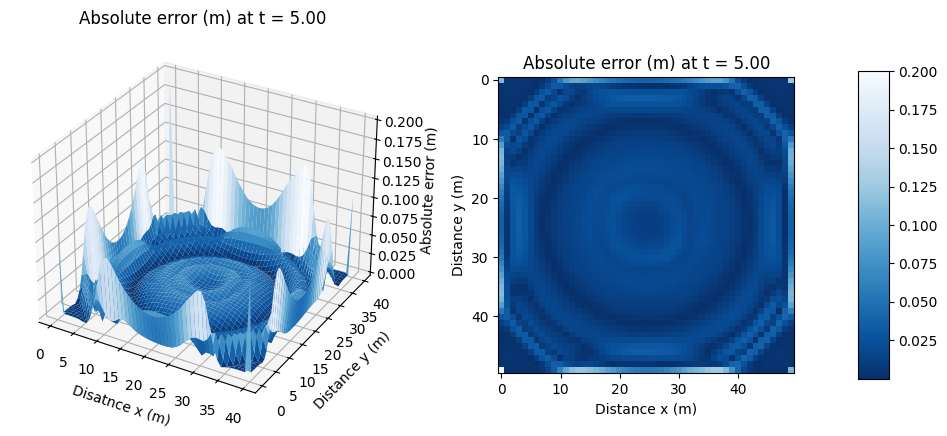

In [633]:
# Prepare grid
X, Y = np.meshgrid(x, y)
cmap = 'Blues_r'
idx = -1

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, np.abs(pred_all[idx]-u[idx]), cmap=cmap)
ax.set_title(f'Absolute error (m) at t = {t_all[idx]:.2f}')
ax.set_xlabel('Disatnce x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('Absolute error (m)')
#fig.colorbar(surf, ax=ax, shrink=0.8, aspect=10, pad=0.15)  # Colorbar for 3D plot

ax1 = fig.add_subplot(122)
heatmap = ax1.imshow(np.abs(pred_all[idx]-u[idx]), cmap=cmap)
ax1.set_title(f'Absolute error (m) at t = {t_all[idx]:.2f}')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
fig.colorbar(heatmap, ax=ax1, shrink=0.8, aspect=10, pad = 0.15) # Add colorbar

plt.show()
